## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the RU-EN translation task.

Basic approach using RNNs as encoder and decoder is implemented for you.

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* Transformer/CNN/<whatever you select> encoder (with or without positional encoding)

* attention/self-attention mechanism (**highly recommended**)

* custom tokenization (BPE units, other subword approaches)

to improve the translation quality.

--------

* __Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

* Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [ ]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext

In [1]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
--2024-03-08 21:17:19--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12,31M  56,4MB/s    in 0,2s    

2024-03-08 21:17:20 (56,4 MB/s) - ‘data.txt’ saved [12905334/12905334]



#### Grading criteria

**100%**
- implementation of at least 3 model improvements over baseline
- threshold of 27 BLEU on test corpus
- experimental results and conclusions in human-readable format :)

**70%**
- implementation of at least 2 model improvements over baseline
- threshold of 25 BLEU on test corpus
- experimental results and conclusions in human-readable format :)

**30%**
- implementation of at least 1 model improvement over baseline
- threshold of 21 BLEU on test corpus
- experimental results and conclusions in human-readable format :)


------

#### **Note: Please do not use pretrained machine translation / BERT / LLM checkpoints. All such solutions will be graded at 30% pts.**


### Warning! The code below is deeeeeeeply deprecated and is is provided only as simple guide.
We suggest you to stick to most recent pipelines here, e.g. by Huggingface:
* Example notebook: [link](https://github.com/huggingface/notebooks/blob/main/examples/translation.ipynb)
* Converting your own dataset to specific format: [link](https://discuss.huggingface.co/t/correct-way-to-create-a-dataset-from-a-csv-file/15686/15)

In [2]:
# old deprecated code
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
# from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


/home/pavel/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [3]:
# here is an instrument for smart tokenize the input sentence
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [2]:
# import sentencepiece as spm
# import pandas as pd

# #! So, we know, that in the data file we have 2 columns the first one -- sentense in english and the second one -- the sentense in russian
# data = pd.read_csv(path_do_data, sep = "\t", header = None).sample(frac = .8)

# #! We separate this sentenses to the independent files
# data[1].to_csv("ru.txt", sep = '\t', header = False, index = False)
# data[0].to_csv("eng.txt", sep = '\t', header = False, index = False)

# #! now we have a sentensen in english and russian, so, we can to train bpe tokenizer on this sentenses to use it later to build a vocabulary of tokens
# spm.SentencePieceTrainer.train(input = 'ru.txt', model_prefix = 'm_ru', vocab_size = 2500, model_type = 'bpe')
# spm.SentencePieceTrainer.train(input = 'eng.txt', model_prefix = 'm_eng', vocab_size = 2500, model_type = 'bpe')

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: ru.txt
  input_format: 
  model_prefix: m_ru
  model_type: BPE
  vocab_size: 2500
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential_privac

In [5]:

# #! trained bpe tokenise models are saved in .model files
# def bpe_tokenizer_en(x):
#   return spm.SentencePieceProcessor(model_file = 'm_eng.model').encode(x, out_type = str)

# def bpe_tokenizer_ru(x):
#   return spm.SentencePieceProcessor(model_file = 'm_ru.model').encode(x, out_type = str)

In [4]:
# Field is a bacis structure of the torchtext module
# it provide us to define the preprocessing pipeline of our data
SRC = Field(tokenize=tokenize, #  The function used to tokenize strings using this field into sequential examples
            init_token = '<sos>', # A token that will be prepended to every example using this field
            eos_token = '<eos>', #  A token that will be appended to every example using this field
            lower = True) # to lowercase the text in this field

TRG = Field(tokenize=tokenize,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

dataset = torchtext.legacy.data.TabularDataset(
    path=path_do_data,
    format='tsv', # The format of the data file. One of “CSV”, “TSV”, or “JSON”
    fields=[('trg', TRG), ('src', SRC)]
)

In [7]:
# #! for this moment we already have trained tokenisers for english and russian, so, we use it to encode the data to the indexes
# SRC = Field(tokenize=bpe_tokenizer_en,
#             init_token = '<sos>',
#             eos_token = '<eos>',
#             fix_length = 100, # need is we use bpe tokenesation
#             lower = True)

# TRG = Field(tokenize=bpe_tokenizer_ru,
#             init_token = '<sos>',
#             eos_token = '<eos>',
#             fix_length = 100,
#             lower = True)

# dataset = torchtext.legacy.data.TabularDataset(
#     path=path_do_data,
#     format='tsv', # The format of the data file. One of “CSV”, “TSV”, or “JSON”
#     fields=[('trg', TRG), ('src', SRC)]
# )

In [5]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [6]:
# the data examples are dictionaries of two elements.
# keys are trg and src and the values are lists of the splited sentences.
vars(train_data.examples[1])

{'trg': ['each',
  'of',
  'the',
  'rooms',
  'at',
  'the',
  'guest',
  'house',
  'comes',
  'equipped',
  'with',
  'a',
  'satellite',
  'tv',
  'and',
  'a',
  'private',
  'bathroom',
  '.'],
 'src': ['во',
  'всех',
  'номерах',
  'гостевого',
  'дома',
  'есть',
  'спутниковое',
  'телевидение',
  'и',
  'собственная',
  'ванная',
  'комната',
  '.']}

In [7]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [8]:

#! on this step we not only build the vocab, but also encode tokens to the vectors
#!! to tell the truth we even don't really encode it, we juct make smth live string2idx, and in the translation function we will be able to use predected vector of indexes to build the words in translated sentense
#! in addition we append the token <unk> to the vocab

#! in the nn we will have the embedding layer; why do we need it if we've already encoded our tokens on this step?
#! we do it, cz in the RNN we must have the vectors of the same dimention, so, by  using embedding layer, we make a static internal RNN representation vector dimention
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [9]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9237
Unique tokens in target (en) vocabulary: 6694


Here are tokens from original (RU) corpus:

In [10]:
SRC.vocab.itos[::1000]

['<unk>',
 'отдельной',
 'rio',
 'кухонной',
 'charming',
 'центральным',
 'legacy',
 'хайдарабада',
 'духа',
 'торки']

And from target (EN) corpus:

In [11]:
TRG.vocab.itos[::1000]

['<unk>', 'palma', 'chiado', 'dreams', 'louise', 'sevastopol', 'maintained']

And here is example from train dataset:

In [12]:
print(vars(train_data.examples[9]))

{'trg': ['extras', 'include', 'garden', 'furniture', 'and', 'an', 'open', 'terrace', '.'], 'src': ['кроме', 'того', ',', 'в', 'распоряжении', 'гостей', 'садовая', 'мебель', 'и', 'открытая', 'терраса', '.']}


Let's check the length distributions:

Length distribution in Train data


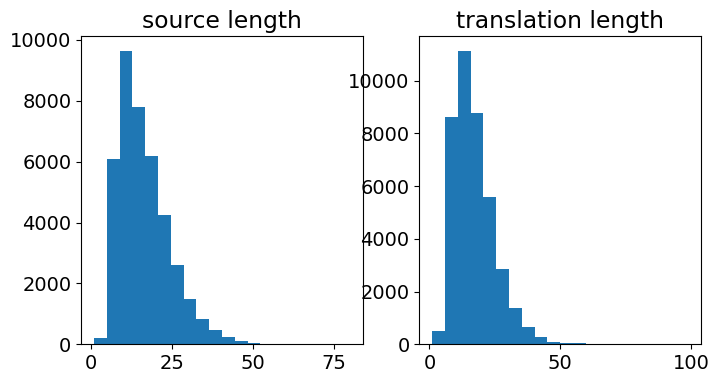

In [13]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


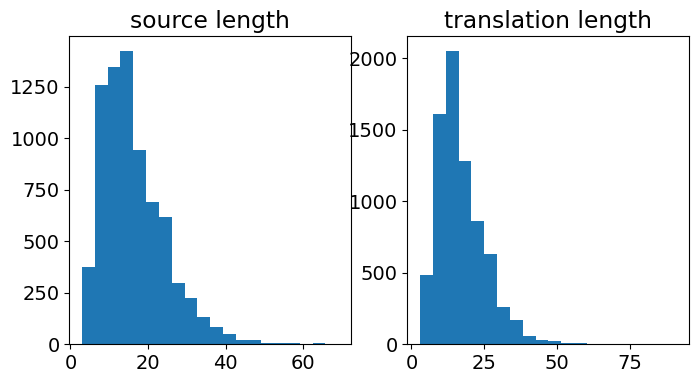

In [14]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week02 practice__

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
device

device(type='cpu')

In [17]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=_len_sort_key
)

In [18]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)
# the first dimention of tensor is a max length of the item
# the second dimention of the tensor is a number of items
#? such tensors contain the one hot vectors of ... 


[torchtext.legacy.data.batch.Batch of size 128]
	[.trg]:[torch.LongTensor of size 57x128]
	[.src]:[torch.LongTensor of size 50x128]
torch.Size([50, 128]) torch.Size([57, 128])


In [19]:

#! Lets try to output one of the tensors
#! we can see and assume, that the first number in each column is 2 and it's represent the <sos> token
#! and we have a lot of 1 number, we can assume, it's represent a <pad> token
print(x.src)

tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [  15,   69,  365,  ...,   30,   19,  525],
        [  14,  322, 4206,  ...,  306,   20, 1383],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]])


In [20]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [21]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [22]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9237, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6694, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6694, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,868,774 trainable parameters


In [24]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [25]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()

    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        #! import source and dst texts from batch for traning
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        #! get the output with model (outout is a vector)
        output = model(src, trg)

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        #! by this action ([1:]) we cut the <sos> token and convert the output from the tensor to the vector
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]

        loss = criterion(output, trg)

        loss.backward()

        # Let's clip the gradient
        #! it's done to prevent limitless grouth of the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()

            plt.show()


    return epoch_loss / len(iterator)

In [26]:
def evaluate(model, iterator, criterion):
    #! switch the model to the evaluate mode
    model.eval()

    epoch_loss = 0

    history = []
    #! do a predictio without calculating gradients
    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg
            #! give the prediction of the input, using the model
            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [27]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [28]:
train_history = []
valid_history = []

N_EPOCHS = 3
CLIP = 1

best_valid_loss = float('inf')

In [29]:
from utils import write_model_title_log, write_model_train_log

In [30]:
write_model_title_log("logfile.log", 
                      f"[MODEL = Seq2Seq]\n")

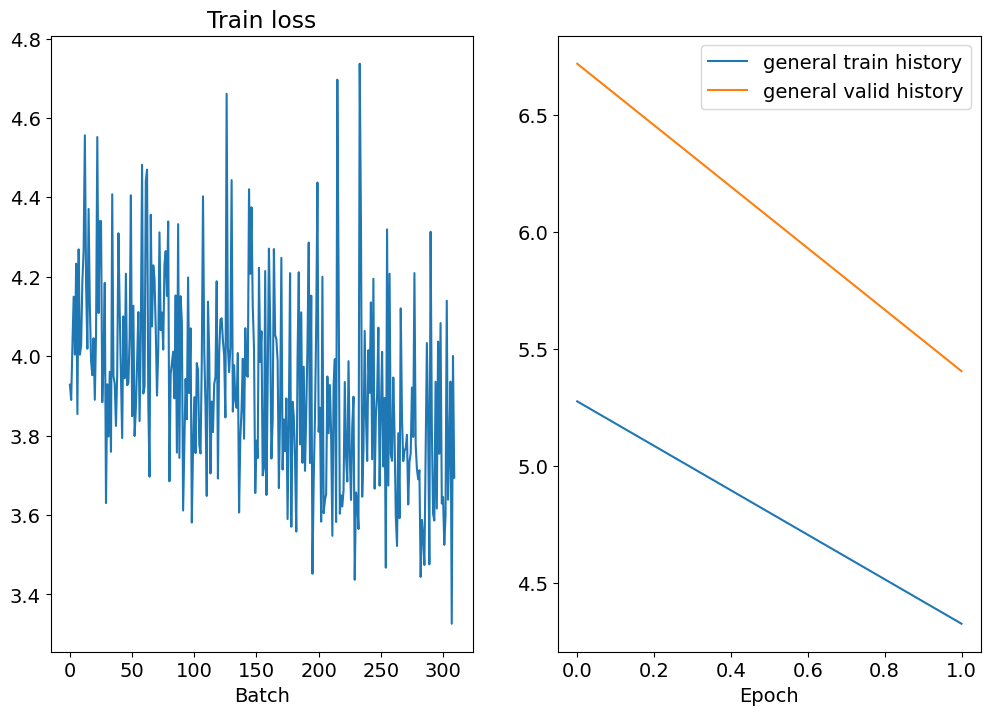

"\nOn the last epoch we could see that the train loss on the left plot is not \ndecrease anymore. That means, that the model came tho the point of the local min.\n\nPPL stands for perplexity. This quantity is directly computable from the negative log-likelihood (and the number of samples), \nso it's odd that the authors would report both.\n"

In [31]:
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # if valid_loss < best_valid_loss:
    #     best_valid_loss = valid_loss
    #     torch.save(model.state_dict(), 'tut1-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    #TODO: make the output of the log to the separate file
    write_model_train_log("logfile.log",
                          epoch,
                          [epoch_mins, epoch_secs],
                          train_loss,
                          valid_loss)

'''
On the last epoch we could see that the train loss on the left plot is not 
decrease anymore. That means, that the model came tho the point of the local min.

PPL stands for perplexity. This quantity is directly computable from the negative log-likelihood (and the number of samples), 
so it's odd that the authors would report both.
'''

__Let's take a look at our network quality__:

In [ ]:
# del utils

In [32]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

/tmp/ipykernel_340511/3680124227.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [33]:
batch = next(iter(test_iterator))

In [34]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: the unit is fitted with a kitchen .
Generated: shower , a and a .

Original: there is free shuttle service at the property .
Generated: freewifi is available .



In [35]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [36]:
'''
tqdm means "progress" in Arabic 
and is an abbreviation for "I love you so much" in Spanish (te quiero demasiado).
'''
import tqdm

In [37]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)

        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:11,  5.18it/s]


In [38]:

#! the BLEU is a one way how to evaluate the quality of the machine translating
#! original BLEU uses a counting of the same words, bigramms, etc and accumulate it to the one score
#! corpus_bleu is able to give an input of several sentenses and it's translations and makes some kind of average BLEU score of all of this transaltions
seq2seq_model_bleu_score = corpus_bleu([[text] for text in original_text], generated_text) * 100
seq2seq_model_bleu_score

5.771097701454099

# For now lets try to make a mechanism of self attention in exested Seq2seq nn

In [ ]:
'''
In a conclusion we just add attention mechanism to the
decoder code
'''

In [39]:
import attention_nn
AttentionEncoder = attention_nn.Encoder
AttentionDecoder = attention_nn.Decoder
AttentionSeq2Seq = attention_nn.Seq2Seq

In [40]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = AttentionEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = AttentionDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)


# dont forget to put the model to the right device
model = AttentionSeq2Seq(enc, dec, device).to(device)

In [41]:
model.apply(init_weights)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,868,774 trainable parameters


In [42]:
PAD_IDX = TRG.vocab.stoi['']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [43]:

train_history = []
valid_history = []

# N_EPOCHS = 20
N_EPOCHS = 3
CLIP = 5

best_valid_loss = float('inf')

In [45]:
write_model_title_log("logfile.log", 
                      f"[MODEL = Seq2Seq + attention]\n")

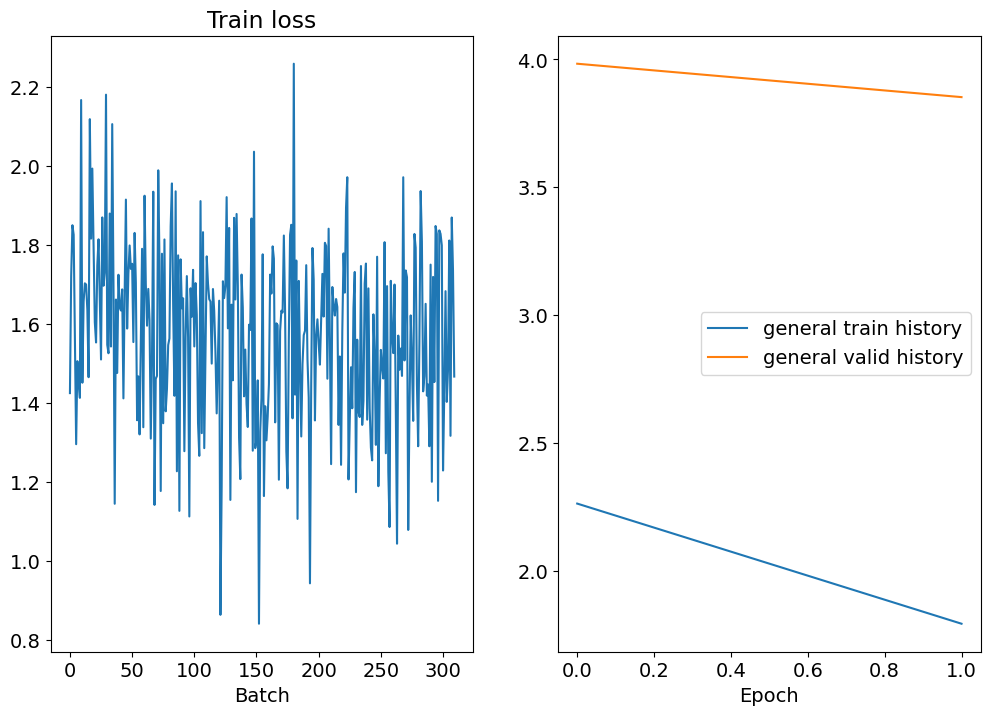

In [46]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # if valid_loss < best_valid_loss:
    #     best_valid_loss = valid_loss
    #     torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    write_model_train_log("logfile.log",
                          epoch,
                          [epoch_mins, epoch_secs],
                          train_loss,
                          valid_loss)

In [47]:
batch = next(iter(test_iterator))

In [48]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: the unit is fitted with a kitchen .
Generated: sheffield ).

Original: there is free shuttle service at the property .
Generated: free wifi parking



In [49]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

59it [00:11,  5.26it/s]


In [50]:
seq2seq_with_attention_model_bleu_score = corpus_bleu([[text] for text in original_text], generated_text) * 100
seq2seq_model_bleu_score

5.771097701454099

# Transformet

In [51]:
import transformer
from transformer import Seq2SeqTransformer

In [52]:
torch.manual_seed(0)
PAD_IDX = TRG.vocab.stoi['']


SRC_VOCAB_SIZE = len(SRC.vocab)
TGT_VOCAB_SIZE = len(TRG.vocab)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, 
                                 NUM_DECODER_LAYERS, 
                                 EMB_SIZE, 
                                 NHEAD, 
                                 SRC_VOCAB_SIZE, 
                                 TGT_VOCAB_SIZE, 
                                 FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

A couple of words about masks.

Here we have to generate a couple types of masks: mask for attention mechanism and mask for padding ignoring. The first one type is using for effective calculation of the attention vectors. The second one needs to the ignore padding in the sentenses.

More information:
1) https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
2) https://stackoverflow.com/questions/62170439/difference-between-src-mask-and-src-key-padding-mask
3) ask Chat GPT for an answer

Anyway, I understand why do we need this masks more or less. If you're not -- it's so sad...

In [53]:
def generate_square_subsequent_mask(sz, DEVICE):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt, DEVICE):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len, DEVICE)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [54]:
def train_epoch(model, optimizer, iterator, DEVICE, train_history=None, valid_history=None):
    model.train()
    losses = 0
    history = []
    
    for i, batch in enumerate(iterator):
        src = batch.src.to(DEVICE)
        tgt = batch.trg.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, DEVICE)

        logits = model(src, 
                       tgt_input, 
                       src_mask, 
                       tgt_mask,
                       src_padding_mask, 
                       tgt_padding_mask, 
                       src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
        # plot
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()
        

    return losses / len(iterator)


def evaluate(model, iterator, DEVICE):
    model.eval()
    losses = 0

    for i, batch in enumerate(iterator):
        src = batch.src.to(DEVICE)
        tgt = batch.trg.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, DEVICE)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        
        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(iterator)

In [55]:
print(f'The model has {count_parameters(transformer):,} trainable parameters')

The model has 24,215,590 trainable parameters


In [57]:
write_model_title_log("logfile.log", 
                      f"[MODEL = Transformer]\n")

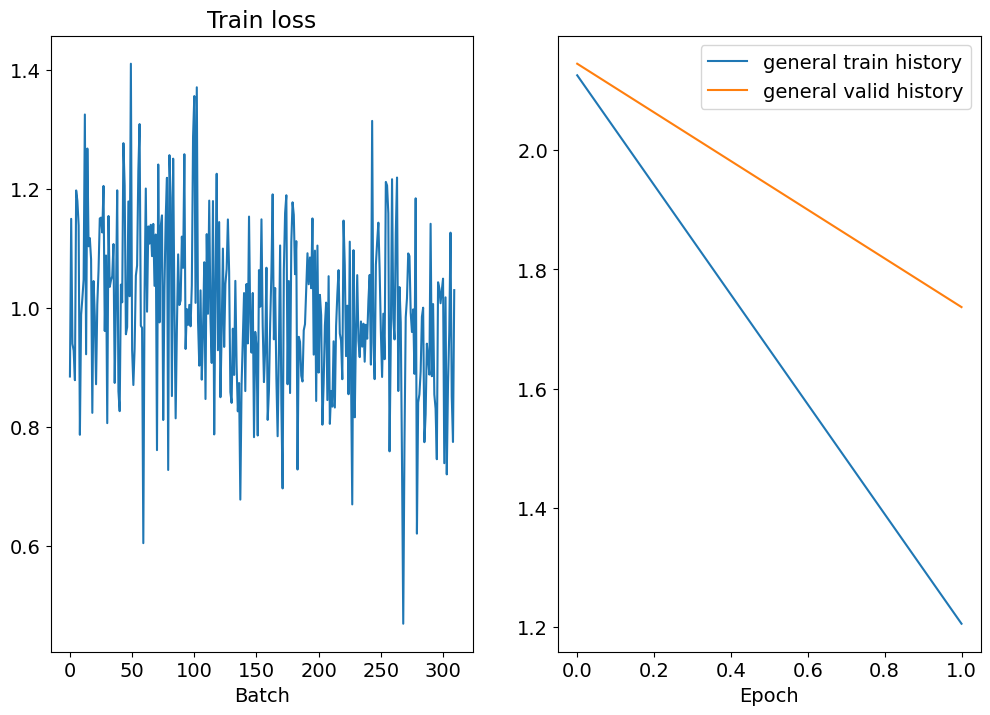

In [58]:
train_history = []
valid_history = []
from timeit import default_timer as timer
NUM_EPOCHS = 3

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer, train_iterator, device, train_history, valid_history)
    end_time = timer()
    val_loss = evaluate(transformer, valid_iterator, device)
    train_history.append(train_loss)
    valid_history.append(val_loss)
    write_model_train_log("logfile.log",
                          epoch,
                          [epoch_mins, epoch_secs],
                          train_loss,
                          valid_loss)

In [59]:
transformer.eval()
original_text = []
generated_text = []

with torch.no_grad():

  for i, batch in tqdm.tqdm(enumerate(test_iterator)):
      src = batch.src.to(device)
      tgt = batch.trg.to(device)

      tgt_input = tgt[:-1, :]

      src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, device)

      logits = transformer(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
      
      tgt_out = tgt[1:, :]
      logits = logits.argmax(dim=-1)
      generated_text.extend([get_text(x, TRG.vocab) for x in logits.cpu().numpy().T])
      original_text.extend([get_text(x, TRG.vocab) for x in tgt.cpu().numpy().T])

59it [00:13,  4.51it/s]


In [61]:
transformer_model_bleu_score = corpus_bleu([[text] for text in original_text], generated_text) * 100
transformer_model_bleu_score

19.353006387596263

In [62]:
bleu_scores = [
    seq2seq_model_bleu_score,
    seq2seq_with_attention_model_bleu_score,
    transformer_model_bleu_score
]
models = [
    "seq2seq",
    "seq2seq + attention",
    "transformer"
]

In [63]:
def add_bar_labels(obj_x, obj_y) -> None:
    for x, y in zip(obj_x, obj_y):
        plt.text(x, y, y, ha='center')

Text(0, 0.5, 'BLEU score')

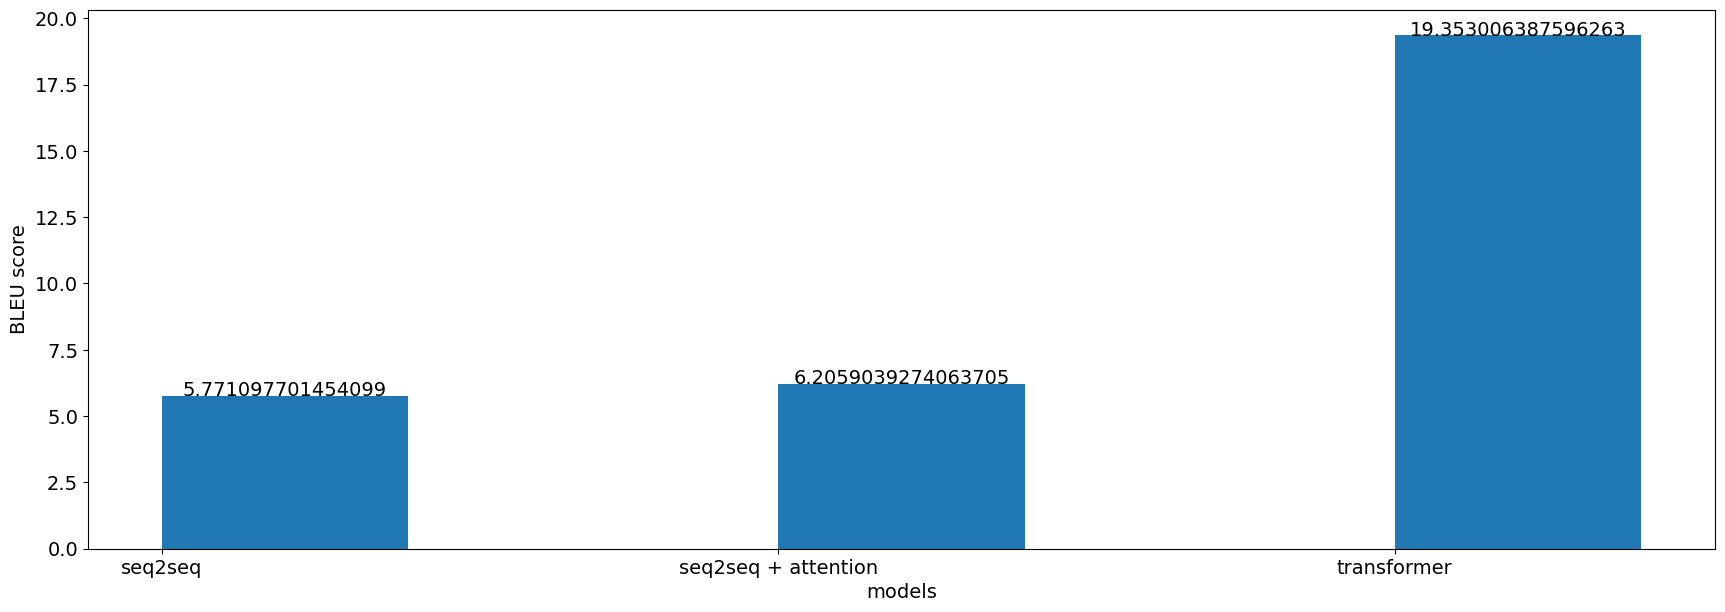

In [64]:
import numpy as np

x_ticks = np.arange(0, len(models)*5, 5)
standart_width = 2

fig = plt.figure(figsize=(21, 7))

plt.bar(x_ticks + standart_width/2, bleu_scores, width=standart_width)
add_bar_labels(x_ticks + standart_width/2, bleu_scores)

plt.xticks(x_ticks, models)
plt.xlabel("models")
plt.ylabel("BLEU score")
# plt.title(f"")